In [1]:
%matplotlib notebook

import sys
import itertools
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from typing import List, Tuple


In [3]:
def generate_train_set(nb_train: int, seq_len: int, max_no: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates tensor of train and label data with one-hot encoding.
    nb_train - number of train sets
    seq_len - length of a train set
    max_no - possible values: [0, max_no)
    """
    X_train: np.ndarray = np.zeros((nb_train, seq_len, max_no), dtype=np.float32)
    Y_train: np.ndarray = np.zeros((nb_train, seq_len, max_no), dtype=np.float32)

    x: np.ndarray = np.random.randint(max_no, size=(nb_train, seq_len))
    y: np.ndarray = np.sort(x, axis=1)
    
    # One-hot encoding
    for ind,batch in enumerate(x):
        for j, elem in enumerate(batch):
            X_train[ind, j, elem] = 1

    for ind,batch in enumerate(y):
        for j, elem in enumerate(batch):
            Y_train[ind, j, elem] = 1
    
    return X_train, Y_train

In [56]:
class TensorLinear(object):
    """
    The linear tensor layer applies weights dot product
    and adds bias to input.
    """
    def __init__(self, n_in: int, n_out: int, tensor_order: int, W: np.ndarray=None, b: np.ndarray=None) -> None:
        """Initialse the weight W and bias b parameters
        by sampling uniformly between (-a) and (a)"""
        
        a: float = np.sqrt(6.0 / (n_in + n_out))
        self.W: np.ndarray = (np.random.uniform(-a, a, (n_in, n_out)) 
                  if W is None else W)
        self.b: np.ndarray = (np.zeros((n_out)) if b is None else b)
        # Axes summed over in backprop
        self.bpAxes: Tuple = tuple(range(tensor_order-1))

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Perform forward step transformation"""
        
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X: np.ndarray, gY: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        
        gW: np.ndarray = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB: np.ndarray = np.sum(gY, axis=self.bpAxes)
        gX: np.ndarray = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB
    
    
class LogisticClassifier(object):
    """The logistic layer applies the logistic function to its 
    inputs."""
   
    def forward(self, X: np.ndarray) -> np.ndarray:
        """Simoid activation function. 
        Perform the forward step transformation. """
        return 1. / (1. + np.exp(-X))
    
    def backward(self, Y: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return the gradient with respect to the loss function 
        at the inputs of this layer."""
        # Average by the number of samples and sequence length.
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def loss(self, Y: np.ndarray, T: np.ndarray):
        """Compute the loss at the output."""
        return -np.mean((T * np.log(Y)) + ((1-T) * np.log(1-Y)))

In [13]:

class TanH(object):
    """TanH applies the tanh function to its inputs."""
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        """TanH activation function.
        Perform the forward step transformation."""
        return np.tanh(X) 
    
    def backward(self, Y: float, output_grad: float) -> float:
        """Return the gradient at the inputs of this layer."""
        gTanh: float = 1.0 - (Y**2)
        return (gTanh * output_grad)

# Define internal state update layer
class RecurrentStateUpdate(object):
    """Update a given state."""
    def __init__(self, nbStates: int, W: np.ndarray, b: np.ndarray) -> None:
        """Initialse the linear transformation and tanh transfer 
        function."""
        self.linear: TensorLinear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh: TanH = TanH()

    def forward(self, Xk: np.ndarray, Sk: np.ndarray) -> np.ndarray:
        """Return state k+1 from input and state k."""
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0: np.ndarray, Sk1: np.ndarray, output_grad: np.ndarray) -> Tuple[np.ndarray,
                                                                                           np.ndarray,
                                                                                           np.ndarray,
                                                                                           np.ndarray]:
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        gZ: np.ndarray = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB= self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

# Define layer that unfolds the states over time
class RecurrentStateUnfold(object):
    """Unfold the recurrent states."""
    def __init__(self, nbStates: int, nbTimesteps: int) -> None:
        """Initialse the shared parameters, the inital state and 
        state update function."""
        a: float = np.sqrt(6. / (nbStates * 2))
        self.W: np.ndarray = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b: np.ndarray = np.zeros((self.W.shape[0]))  # Shared bias
        self.S0: np.ndarray = np.zeros(nbStates)  # Initial state
        self.nbTimesteps: int = nbTimesteps  # Timesteps to unfold
        self.stateUpdate: RecurrentStateUpdate = RecurrentStateUpdate(
            nbStates, self.W, self.b)  # State update function
        
    def forward(self, X: np.ndarray) -> np.ndarray:
        """Iteratively apply forward step to all states."""
        # State tensor
        S: np.ndarray = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0  # Set initial state
        for k in range(self.nbTimesteps):
            # Update the states iteratively
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X: np.ndarray, S: np.ndarray, gY: np.ndarray) -> Tuple[np.ndarray,
                                                                              np.ndarray,
                                                                              np.ndarray,
                                                                              np.ndarray]:
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Initialise gradient of state outputs
        gSk: np.ndarray = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        # Initialse gradient tensor for state inputs
        gZ: np.ndarray = np.zeros_like(X)
        gWSum: np.ndarray = np.zeros_like(self.W)  # Initialise weight gradients
        gBSum: np.ndarray = np.zeros_like(self.b)  # Initialse bias gradients
        # Propagate the gradients iteratively
        for k in range(self.nbTimesteps-1, -1, -1):
            # Gradient at state output is gradient from previous state 
            #  plus gradient from output
            gSk += gY[:,k,:]
            # Propgate the gradient back through one state
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW  # Update total weight gradient
            gBSum += gB  # Update total bias gradient
        # Get gradient of initial state over all samples
        gS0: np.ndarray = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0



In [40]:
# Define the full network
class RnnSorter(object):
    """RNN to sort a sequence of numbers"""
    def __init__(self, nb_of_inputs: int, nb_of_outputs: int, nb_of_states: int, 
                 sequence_len: int) -> None:
        """Initialse the network layers."""
        # Input layer
        self.tensorInput: TensorLinear = TensorLinear(nb_of_inputs, nb_of_states, 3)
        # Recurrent layer
        self.rnnUnfold: RecurrentStateUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        # Linear output transform
        self.tensorOutput: TensorLinear = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier: LogisticClassifier = LogisticClassifier()  # Classification output
        
    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Perform the forward propagation of input X through all 
        layers."""
        # Linear input transformation
        recIn: np.ndarray = self.tensorInput.forward(X)
        # Forward propagate through time and return states
        S: np.ndarray = self.rnnUnfold.forward(recIn)
        # Linear output transformation
        Z: np.ndarray = self.tensorOutput.forward(S[:,1:sequence_len+1,:])
        Y: np.ndarray = self.classifier.forward(Z)  # Classification probabilities
        # Return: input to recurrent layer, states, input to classifier, 
        #  output
        return recIn, S, Z, Y
    
    def backward(self, X: np.ndarray, Y: np.ndarray, recIn: np.ndarray, S: np.ndarray, T: np.ndarray) -> Tuple[np.ndarray,
                                                                                                               np.ndarray,
                                                                                                               np.ndarray,
                                                                                                               np.ndarray,
                                                                                                               np.ndarray,
                                                                                                               np.ndarray,
                                                                                                               np.ndarray]:
        """Perform the backward propagation through all layers.
        Input: input samples, network output, intput to recurrent 
        layer, states, targets."""
        gZ = self.classifier.backward(Y, T)  # Get output gradient
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:,1:sequence_len+1,:], gZ)
        # Propagate gradient backwards through time
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        # Return the parameter gradients of: linear output weights, 
        #  linear output bias, recursive weights, recursive bias, #
        #  linear input weights, linear input bias, initial state.
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X: np.ndarray) -> np.ndarray:
        """Get the output probabilities of input X."""
        _, _, _, Y = self.forward(X)
        return Y
    
    def getParamGrads(self, X, T) -> List:
        """Return the gradients with respect to input X and 
        target T as a list. The list has the same order as the 
        get_params_iter iterator."""
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def loss(self, Y: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return the loss of input X w.r.t. targets T."""
        return self.classifier.loss(Y, T)
    
    def get_params_iter(self) -> itertools.chain:
        """Return an iterator over the parameters.
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

In [65]:
# Define train function
def train(nb_train:int, sequence_len: int, max_no: int,
          nb_of_states = 20,
          lmbd: float = 0.5,
          learning_rate: float = 0.05,
          momentum_term: float = 0.9,
          eps: float = 1e-6,
          mb_size: int = 100) -> Tuple[RnnSorter, List]:
    """
    Train the model
    Return model and list of losses.

    Hyper-parameters:
    nb_train - number of train sets
    seq_len - length of a train set
    max_no - possible values: [0, max_no)
    nb_of_states - Number of states in the recurrent layer
    lmbd - Rmsprop lambda
    learning_rate - Learning rate
    momentum_term - Momentum term
    eps - Numerical stability term to prevent division by zero
    mb_size - Size of the minibatches (number of samples)
    """

    X_train, T_train = generate_train_set(nb_train=nb_train, seq_len=sequence_len, max_no=max_no)

    # Create the network
    RNN = RnnSorter(max_no, max_no, nb_of_states, sequence_len)
    # Set the initial parameters
    # Number of parameters in the network
    nbParameters =  sum(1 for _ in RNN.get_params_iter())
    # Rmsprop moving average
    maSquare = [0.0 for _ in range(nbParameters)]
    Vs = [0.0 for _ in range(nbParameters)]  # Momentum

    # Create a list of minibatch losses to be plotted
    ls_of_loss = [
        RNN.loss(RNN.getOutput(X_train[0:mb_size,:,:]), T_train[0:mb_size,:,:])]
    # Iterate over some iterations
    for i in range(5):
        # Iterate over all the minibatches
        for mb in range(nb_train // mb_size):
            X_mb = X_train[mb:mb+mb_size,:,:]  # Input minibatch
            T_mb = T_train[mb:mb+mb_size,:,:]  # Target minibatch
            V_tmp = [v * momentum_term for v in Vs]
            # Update each parameters according to previous gradient
            for pIdx, P in enumerate(RNN.get_params_iter()):
                P += V_tmp[pIdx]
            # Get gradients after following old velocity
            # Get the parameter gradients
            backprop_grads = RNN.getParamGrads(X_mb, T_mb)  
            # Update each parameter seperately
            for pIdx, P in enumerate(RNN.get_params_iter()):
                # Update the Rmsprop moving averages
                maSquare[pIdx] = lmbd * maSquare[pIdx] + (
                    1-lmbd) * backprop_grads[pIdx]**2
                # Calculate the Rmsprop normalised gradient
                pGradNorm = ((
                    learning_rate * backprop_grads[pIdx]) / np.sqrt(
                    maSquare[pIdx]) + eps)
                # Update the momentum
                Vs[pIdx] = V_tmp[pIdx] - pGradNorm     
                P -= pGradNorm   # Update the parameter
            # Add loss to list to plot
            ls_of_loss.append(RNN.loss(RNN.getOutput(X_mb), T_mb))
    return RNN, ls_of_loss

In [111]:
def softmax(x: np.ndarray) -> np.ndarray:
    """
    Create normalized probaility distribution.
    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def MSE(Y: np.ndarray, T: np.ndarray) -> np.ndarray:
    return np.mean((Y-T)**2)

# Define validation function
def validate(RNN: RnnSorter, nb_train:int, seq_len:int, max_no:int) -> float:
    """
    Generate new batch of samples. Compare the predictions to the true answers.
    Return total MSE loss.
    """
    classifier: LogisticClassifier = LogisticClassifier()
    
    X_test: np.ndarray = np.zeros((nb_train, seq_len, max_no), dtype=np.float32)

    x: np.ndarray = np.random.randint(max_no, size=(nb_train, seq_len))
    T_test: np.ndarray = np.sort(x, axis=1)

    for ind,batch in enumerate(x):
        for j, elem in enumerate(batch):
            X_test[ind, j, elem] = 1
    
    # Get the output for the validation batch
    Yf = RNN.getOutput(X_test)
    
    # Apply softmax on the resulting tensor
    for i in range(Yf.shape[0]):
        for j in range(Yf.shape[1]):
            Yf[i,j]=softmax(Yf[i,j])
    Yf: np.ndarray = np.argmax(Yf, axis=2)
        
    mse_loss = MSE(Yf, T_test)
    return mse_loss

def RNNsort(RNN: RnnSorter, sequence: np.ndarray) -> np.ndarray:
    sequence = np.reshape(sequence, (1, -1))
    x: np.ndarray = np.zeros((1, sequence.size, sequence.max()+1), dtype=np.float32)
    for ind,batch in enumerate(sequence):
        for j, elem in enumerate(batch):
            x[ind, j, elem] = 1
            
    out: np.ndarray = RNN.getOutput(x)
    for j in range(out.shape[1]):
        out[0,j]=softmax(out[0,j])
    out: np.ndarray = np.argmax(out, axis=2)
    out = np.reshape(out, (-1))
    return out
    

In [114]:
RNN, losses = train(20000, 6, 3)
loss = validate(RNN, 10, 6, 3)

# Note that 20000 iterations is way to little to get any
# great results (log_loss is around 0.25 on train)
# Hyper-parameter tweaking may bring better results

# However, this model shows that this kind of
# arcitechture (RNN) is suitable for this problem

In [117]:
out = RNNsort(RNN, np.array([1, 2, 1, 0, 2, 0]))
print(out)

[0 0 1 1 2 2]


<IPython.core.display.Javascript object>


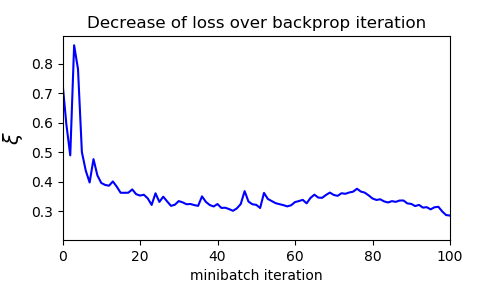

In [116]:
fig = plt.figure(figsize=(5, 3))
plt.plot(losses, 'b-')
plt.xlabel('minibatch iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 100)
fig.subplots_adjust(bottom=0.2)
plt.show()
#